<a href="https://colab.research.google.com/github/khanhlvg/tflite_raspberry_pi/blob/main/object_detection/Train_custom_model_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2021 The TensorFlow Authors.

In [3]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Train a custom object detection model with TensorFlow Lite Model Maker

In this colab notebook, you'll learn how to use the [TensorFlow Lite Model Maker](https://www.tensorflow.org/lite/guide/model_maker) to train a custom object detection model to detect Android figurines and how to put the model on a Raspberry Pi.

The Model Maker library uses *transfer learning* to simplify the process of training a TensorFlow Lite model using a custom dataset. Retraining a TensorFlow Lite model with your own custom dataset reduces the amount of training data required and will shorten the training time.


## Preparation

### Install the required packages
Start by installing the required packages, including the Model Maker package from the [GitHub repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) and the pycocotools library you'll use for evaluation.

In [2]:
#!pip install -r requirements.txt
#!pip install -q tflite-model-maker
#!pip install -q tflite-support
!python --version

Python 2.7.17


Import the required packages.

In [1]:
import numpy as np
import os

from tflite_model_maker.config import ExportFormat, QuantizationConfig
from tflite_model_maker import model_spec
from tflite_model_maker import object_detector

from tflite_support import metadata

import tensorflow as tf
assert tf.__version__.startswith('2')

tf.get_logger().setLevel('ERROR')
from absl import logging
logging.set_verbosity(logging.ERROR)

2022-05-02 17:34:53.957663: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-02 17:34:53.957679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Prepare the dataset

This dataset contains about 70 images of 2 type of Android figurines: an Android and an Android pig. This is an example image from the dataset.

![android_figurine_sample.jpg](https://storage.googleapis.com/download.tensorflow.org/example_images/android_figurine_sample.jpg)

We start with downloading the dataset.

In [6]:
!wget https://storage.googleapis.com/download.tensorflow.org/data/android_figurine.zip
!unzip -q android_figurine.zip

--2022-04-27 14:15:22--  https://storage.googleapis.com/download.tensorflow.org/data/android_figurine.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.181.208, 172.217.16.80, 172.217.19.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.181.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14333895 (14M) [application/zip]
Saving to: ‘android_figurine.zip’

android_figurine.zi 100%[===================>]  13,67M  28,0MB/s    in 0,5s    

2022-04-27 14:15:23 (28,0 MB/s) - ‘android_figurine.zip’ saved [14333895/14333895]



## Train the object detection model

### Step 1: Load the dataset

* Images in `train_data` is used to train the custom object detection model.
* Images in `val_data` is used to check if the model can generalize well to new images that it hasn't seen before.

In [2]:
train_dir = "res/train"
val_dir = "res/val"

In [3]:
import xml.etree.ElementTree as ET
def rename_picture_fileformat_in_annotaion(voc_dataset_dir, annotation, file_format):
    tree = ET.parse('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    root = tree.getroot()
    filename_node = root.find("filename")
    filename_node.text = "{}.{}".format(annotation, file_format)
    tree.write('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))


In [4]:

def add_pose_to_object_annotation(voc_dataset_dir,annotation):
    tree = ET.parse('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    root = tree.getroot()
    object_nodes = root.findall("object")
    for object_node in object_nodes:
        ET.SubElement(object_node, 'pose').text = "Unspecified"
    tree.write('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))


In [5]:
def convert_all_floats_to_ints(voc_dataset_dir, annotation):
    tree = ET.parse('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))
    root = tree.getroot()
    bndbox_nodes = root.findall("./object/bndbox")
    for bndbox_node in bndbox_nodes:
        for child in bndbox_node.getchildren():
            child.text = str(int(float(child.text)))
    tree.write('{}/Annotations/{}.xml'.format(voc_dataset_dir,annotation))


In [6]:
from PIL import Image
import shutil
import zipfile
def order_dataset(destination_dir, voc_dataset_dir):

    shutil.rmtree(destination_dir) if os.path.isdir(destination_dir) else None
    shutil.rmtree(voc_dataset_dir) if os.path.isdir(voc_dataset_dir) else None
    
    assert os.path.isfile("{}.zip".format(voc_dataset_dir)), "There is no dataset named \"{}.zip\"".format(voc_dataset_dir) 
    with zipfile.ZipFile("{}.zip".format(voc_dataset_dir),"r") as zip_dataset:
        zip_dataset.extractall(voc_dataset_dir)

    assert os.path.isdir(voc_dataset_dir), "The directory to the PVOC dataset \"{}\" doesnt exist".format(voc_dataset_dir) 

    os.makedirs(destination_dir, exist_ok=True)
    with open("{}/ImageSets/Main/default.txt".format(voc_dataset_dir)) as file:
        lines = [line.rstrip() for line in file]
        try:
            for line in lines:
                # Files might be in PNG File after exporting in CVAT but we need JPEG
                if os.path.isfile('{}/JPEGImages/{}.PNG'.format(voc_dataset_dir,line)):
                    im1 = Image.open('{}/JPEGImages/{}.PNG'.format(voc_dataset_dir, line))
                    im1.save('{}/{}.jpeg'.format(destination_dir, line))
                    rename_picture_fileformat_in_annotaion(voc_dataset_dir, line,"jpeg")
                # IF files are in JPEG just move them
                elif os.path.isfile('{}/JPEGImages/{}.jpeg'.format(voc_dataset_dir,line)):
                    os.replace('{}/JPEGImages/{}.jpeg'.format(voc_dataset_dir, line),'{}/{}.jpeg'.format(destination_dir, line))
                add_pose_to_object_annotation(voc_dataset_dir, line)
                convert_all_floats_to_ints(voc_dataset_dir,line)
                # Move the Annotation file to the destination_dir
                os.replace('{}/Annotations/{}.xml'.format(voc_dataset_dir, line),'{}/{}.xml'.format(destination_dir, line))

            # Move the labelmap file to the destination_dir
            os.replace('{}/labelmap.txt'.format(voc_dataset_dir),'{}/labelmap.txt'.format(destination_dir))
            shutil.rmtree(voc_dataset_dir)
        except:
            print("No files found in {}".format(voc_dataset_dir))


### Order the dataset into train and validation
make sure to have exported your dataset with a 'PASCAL VOC' format in CVAT.  


| IMPORTANT!!!  The validation and the train datasets HAVE to be exported SEPARATELY!  |
|-----------------------------------------|

In [9]:
order_dataset("res/train","res/train_food_pvoc")
order_dataset("res/val","res/val_food_pvoc")

/tmp/ipykernel_20219/1940612171.py:6: DeprecationWarning: This method will be removed in future versions.  Use 'list(elem)' or iteration over elem instead.
  for child in bndbox_node.getchildren():


In [7]:
from pandas import *
def get_labels() -> list:
    data = read_csv("{}/labelmap.txt".format(train_dir),sep=":",)
    labels = data['# label'].tolist()
    try:
        labels.remove('background')
    except:
        print("no background variables in labelmap.txt")
    return labels

def get_label_color(label, file="{}/labelmap.txt".format(train_dir)) -> list:
    data = read_csv(file ,sep=":",)
    index = data.index[data['# label'] == label].to_list()[0]
    color_list = data['color_rgb'][index].replace("[","").replace("]","").split(",")
    color=()
    for rgbstring in color_list:
        color = color + (int(rgbstring),)
    return color


get_label_color("grape", "res/train/labelmap.txt")

(0, 0, 128)

In [13]:
train_data = object_detector.DataLoader.from_pascal_voc(
    'res/train',
    'res/train',
    get_labels()
)

val_data = object_detector.DataLoader.from_pascal_voc(
    'res/val',
    'res/val',
    get_labels()
)

### Step 2: Select a model architecture

EfficientDet-Lite[0-4] are a family of mobile/IoT-friendly object detection models derived from the [EfficientDet](https://arxiv.org/abs/1911.09070) architecture.

Here is the performance of each EfficientDet-Lite models compared to each others.

| Model architecture | Size(MB)* | Latency(ms)** | Average Precision*** |
|--------------------|-----------|---------------|----------------------|
| EfficientDet-Lite0 | 4.4       | 146           | 25.69%               |
| EfficientDet-Lite1 | 5.8       | 259           | 30.55%               |
| EfficientDet-Lite2 | 7.2       | 396           | 33.97%               |
| EfficientDet-Lite3 | 11.4      | 716           | 37.70%               |
| EfficientDet-Lite4 | 19.9      | 1886          | 41.96%               |

<i> * Size of the integer quantized models. <br/>
** Latency measured on Raspberry Pi 4 using 4 threads on CPU. <br/>
*** Average Precision is the mAP (mean Average Precision) on the COCO 2017 validation dataset.
</i>

In this notebook, we use EfficientDet-Lite0 to train our model. You can choose other model architectures depending on whether speed or accuracy is more important to you.

In [11]:
spec = model_spec.get('efficientdet_lite4')

2022-04-29 17:13:40.672478: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-29 17:13:40.672827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 17:13:40.672857: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-29 17:13:40.672881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-29 17:13:40.672904: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

### Step 3: Train the TensorFlow model with the training data.

* Set `epochs = 20`, which means it will go through the training dataset 20 times. You can look at the validation accuracy during training and stop when you see validation loss (`val_loss`) stop decreasing to avoid overfitting.
* Set `batch_size = 4` here so you will see that it takes 15 steps to go through the 62 images in the training dataset.
* Set `train_whole_model=True` to fine-tune the whole model instead of just training the head layer to improve accuracy. The trade-off is that it may take longer to train the model.

In [12]:
model = object_detector.create(train_data, model_spec=spec, batch_size=4, train_whole_model=True, epochs=20, validation_data=val_data)

Epoch 1/20


2022-04-29 17:13:53.583982: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - ETA: 0s - det_loss: 0.9088 - cls_loss: 0.4538 - box_loss: 0.0091 - reg_l2_loss: 0.1085 - loss: 1.0173 - learning_rate: 0.0046 - gradient_norm: 4.2925

2022-04-29 17:22:32.694214: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 541s 1s/step - det_loss: 0.9074 - cls_loss: 0.4533 - box_loss: 0.0091 - reg_l2_loss: 0.1085 - loss: 1.0159 - learning_rate: 0.0046 - gradient_norm: 4.2869 - val_det_loss: 0.5285 - val_cls_loss: 0.3144 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.1086 - val_loss: 0.6371
Epoch 2/20
390/390 [==============================] - ETA: 0s - det_loss: 0.4480 - cls_loss: 0.2544 - box_loss: 0.0039 - reg_l2_loss: 0.1086 - loss: 0.5566 - learning_rate: 0.0012 - gradient_norm: 3.1733

2022-04-29 17:31:06.589173: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 513s 1s/step - det_loss: 0.4479 - cls_loss: 0.2545 - box_loss: 0.0039 - reg_l2_loss: 0.1086 - loss: 0.5565 - learning_rate: 0.0012 - gradient_norm: 3.1733 - val_det_loss: 0.4474 - val_cls_loss: 0.2978 - val_box_loss: 0.0030 - val_reg_l2_loss: 0.1086 - val_loss: 0.5559
Epoch 3/20
390/390 [==============================] - ETA: 0s - det_loss: 0.4207 - cls_loss: 0.2328 - box_loss: 0.0038 - reg_l2_loss: 0.1086 - loss: 0.5293 - learning_rate: 0.0012 - gradient_norm: 3.3895

2022-04-29 17:39:39.790282: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 513s 1s/step - det_loss: 0.4204 - cls_loss: 0.2327 - box_loss: 0.0038 - reg_l2_loss: 0.1086 - loss: 0.5290 - learning_rate: 0.0012 - gradient_norm: 3.3857 - val_det_loss: 0.5140 - val_cls_loss: 0.3058 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.1086 - val_loss: 0.6226
Epoch 4/20
390/390 [==============================] - ETA: 0s - det_loss: 0.3897 - cls_loss: 0.2197 - box_loss: 0.0034 - reg_l2_loss: 0.1086 - loss: 0.4982 - learning_rate: 0.0011 - gradient_norm: 3.4224

2022-04-29 17:48:12.224913: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 512s 1s/step - det_loss: 0.3894 - cls_loss: 0.2196 - box_loss: 0.0034 - reg_l2_loss: 0.1086 - loss: 0.4980 - learning_rate: 0.0011 - gradient_norm: 3.4215 - val_det_loss: 0.4468 - val_cls_loss: 0.2842 - val_box_loss: 0.0033 - val_reg_l2_loss: 0.1086 - val_loss: 0.5553
Epoch 5/20
390/390 [==============================] - ETA: 0s - det_loss: 0.3587 - cls_loss: 0.2086 - box_loss: 0.0030 - reg_l2_loss: 0.1086 - loss: 0.4673 - learning_rate: 0.0011 - gradient_norm: 3.1630

2022-04-29 17:56:45.050607: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 536s 1s/step - det_loss: 0.3586 - cls_loss: 0.2086 - box_loss: 0.0030 - reg_l2_loss: 0.1086 - loss: 0.4672 - learning_rate: 0.0011 - gradient_norm: 3.1639 - val_det_loss: 0.5668 - val_cls_loss: 0.3397 - val_box_loss: 0.0045 - val_reg_l2_loss: 0.1086 - val_loss: 0.6753
Epoch 6/20
390/390 [==============================] - ETA: 0s - det_loss: 0.3402 - cls_loss: 0.1996 - box_loss: 0.0028 - reg_l2_loss: 0.1085 - loss: 0.4487 - learning_rate: 0.0010 - gradient_norm: 3.2453

2022-04-29 18:05:42.003798: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.3398 - cls_loss: 0.1994 - box_loss: 0.0028 - reg_l2_loss: 0.1085 - loss: 0.4484 - learning_rate: 0.0010 - gradient_norm: 3.2443 - val_det_loss: 0.5198 - val_cls_loss: 0.3330 - val_box_loss: 0.0037 - val_reg_l2_loss: 0.1085 - val_loss: 0.6284
Epoch 7/20
390/390 [==============================] - ETA: 0s - det_loss: 0.3178 - cls_loss: 0.1882 - box_loss: 0.0026 - reg_l2_loss: 0.1085 - loss: 0.4264 - learning_rate: 9.2224e-04 - gradient_norm: 3.2423

2022-04-29 18:14:15.575524: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.3178 - cls_loss: 0.1882 - box_loss: 0.0026 - reg_l2_loss: 0.1085 - loss: 0.4264 - learning_rate: 9.2213e-04 - gradient_norm: 3.2408 - val_det_loss: 0.5781 - val_cls_loss: 0.3676 - val_box_loss: 0.0042 - val_reg_l2_loss: 0.1085 - val_loss: 0.6866
Epoch 8/20
390/390 [==============================] - ETA: 0s - det_loss: 0.3184 - cls_loss: 0.1899 - box_loss: 0.0026 - reg_l2_loss: 0.1085 - loss: 0.4269 - learning_rate: 8.2783e-04 - gradient_norm: 3.5617

2022-04-29 18:22:49.381435: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.3182 - cls_loss: 0.1899 - box_loss: 0.0026 - reg_l2_loss: 0.1085 - loss: 0.4267 - learning_rate: 8.2771e-04 - gradient_norm: 3.5602 - val_det_loss: 0.4766 - val_cls_loss: 0.3018 - val_box_loss: 0.0035 - val_reg_l2_loss: 0.1085 - val_loss: 0.5852
Epoch 9/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2935 - cls_loss: 0.1795 - box_loss: 0.0023 - reg_l2_loss: 0.1085 - loss: 0.4020 - learning_rate: 7.2788e-04 - gradient_norm: 3.3144

2022-04-29 18:31:24.107678: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2933 - cls_loss: 0.1795 - box_loss: 0.0023 - reg_l2_loss: 0.1085 - loss: 0.4018 - learning_rate: 7.2775e-04 - gradient_norm: 3.3132 - val_det_loss: 0.5627 - val_cls_loss: 0.3623 - val_box_loss: 0.0040 - val_reg_l2_loss: 0.1085 - val_loss: 0.6712
Epoch 10/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2823 - cls_loss: 0.1733 - box_loss: 0.0022 - reg_l2_loss: 0.1085 - loss: 0.3908 - learning_rate: 6.2513e-04 - gradient_norm: 3.2629

2022-04-29 18:39:57.669042: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 535s 1s/step - det_loss: 0.2822 - cls_loss: 0.1732 - box_loss: 0.0022 - reg_l2_loss: 0.1085 - loss: 0.3906 - learning_rate: 6.2500e-04 - gradient_norm: 3.2594 - val_det_loss: 0.5371 - val_cls_loss: 0.3408 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.1085 - val_loss: 0.6456
Epoch 11/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2699 - cls_loss: 0.1701 - box_loss: 0.0020 - reg_l2_loss: 0.1085 - loss: 0.3784 - learning_rate: 5.2238e-04 - gradient_norm: 3.2341

2022-04-29 18:48:52.279511: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2712 - cls_loss: 0.1704 - box_loss: 0.0020 - reg_l2_loss: 0.1085 - loss: 0.3797 - learning_rate: 5.2225e-04 - gradient_norm: 3.2514 - val_det_loss: 0.6110 - val_cls_loss: 0.3956 - val_box_loss: 0.0043 - val_reg_l2_loss: 0.1085 - val_loss: 0.7195
Epoch 12/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2728 - cls_loss: 0.1717 - box_loss: 0.0020 - reg_l2_loss: 0.1085 - loss: 0.3813 - learning_rate: 4.2242e-04 - gradient_norm: 3.3480

2022-04-29 18:57:27.186338: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2726 - cls_loss: 0.1716 - box_loss: 0.0020 - reg_l2_loss: 0.1085 - loss: 0.3811 - learning_rate: 4.2230e-04 - gradient_norm: 3.3449 - val_det_loss: 0.5298 - val_cls_loss: 0.3351 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.1085 - val_loss: 0.6382
Epoch 13/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2579 - cls_loss: 0.1678 - box_loss: 0.0018 - reg_l2_loss: 0.1085 - loss: 0.3663 - learning_rate: 3.2799e-04 - gradient_norm: 3.2512

2022-04-29 19:06:01.083718: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2582 - cls_loss: 0.1680 - box_loss: 0.0018 - reg_l2_loss: 0.1085 - loss: 0.3666 - learning_rate: 3.2787e-04 - gradient_norm: 3.2534 - val_det_loss: 0.6579 - val_cls_loss: 0.4284 - val_box_loss: 0.0046 - val_reg_l2_loss: 0.1085 - val_loss: 0.7664
Epoch 14/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2579 - cls_loss: 0.1667 - box_loss: 0.0018 - reg_l2_loss: 0.1085 - loss: 0.3664 - learning_rate: 2.4166e-04 - gradient_norm: 3.2413

2022-04-29 19:14:34.933747: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2579 - cls_loss: 0.1667 - box_loss: 0.0018 - reg_l2_loss: 0.1085 - loss: 0.3664 - learning_rate: 2.4156e-04 - gradient_norm: 3.2406 - val_det_loss: 0.5179 - val_cls_loss: 0.3403 - val_box_loss: 0.0036 - val_reg_l2_loss: 0.1084 - val_loss: 0.6264
Epoch 15/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2585 - cls_loss: 0.1664 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3670 - learning_rate: 1.6579e-04 - gradient_norm: 3.2645

2022-04-29 19:23:09.308836: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 535s 1s/step - det_loss: 0.2587 - cls_loss: 0.1665 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3672 - learning_rate: 1.6570e-04 - gradient_norm: 3.2644 - val_det_loss: 0.5396 - val_cls_loss: 0.3503 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.1084 - val_loss: 0.6481
Epoch 16/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2569 - cls_loss: 0.1643 - box_loss: 0.0019 - reg_l2_loss: 0.1084 - loss: 0.3654 - learning_rate: 1.0244e-04 - gradient_norm: 3.2299

2022-04-29 19:32:04.225126: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2568 - cls_loss: 0.1642 - box_loss: 0.0019 - reg_l2_loss: 0.1084 - loss: 0.3652 - learning_rate: 1.0237e-04 - gradient_norm: 3.2281 - val_det_loss: 0.5488 - val_cls_loss: 0.3546 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.1084 - val_loss: 0.6572
Epoch 17/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2545 - cls_loss: 0.1635 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3629 - learning_rate: 5.3347e-05 - gradient_norm: 3.2381

2022-04-29 19:40:38.190493: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2544 - cls_loss: 0.1635 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3628 - learning_rate: 5.3297e-05 - gradient_norm: 3.2345 - val_det_loss: 0.5580 - val_cls_loss: 0.3614 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.1084 - val_loss: 0.6665
Epoch 18/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2571 - cls_loss: 0.1652 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3656 - learning_rate: 1.9847e-05 - gradient_norm: 3.1871

2022-04-29 19:49:12.530619: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2571 - cls_loss: 0.1652 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3656 - learning_rate: 1.9818e-05 - gradient_norm: 3.1862 - val_det_loss: 0.5507 - val_cls_loss: 0.3609 - val_box_loss: 0.0038 - val_reg_l2_loss: 0.1084 - val_loss: 0.6591
Epoch 19/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2522 - cls_loss: 0.1619 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3607 - learning_rate: 2.8549e-06 - gradient_norm: 3.1713

2022-04-29 19:57:46.628966: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


390/390 [==============================] - 514s 1s/step - det_loss: 0.2521 - cls_loss: 0.1619 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3606 - learning_rate: 2.8476e-06 - gradient_norm: 3.1697 - val_det_loss: 0.5536 - val_cls_loss: 0.3589 - val_box_loss: 0.0039 - val_reg_l2_loss: 0.1084 - val_loss: 0.6620
Epoch 20/20
390/390 [==============================] - ETA: 0s - det_loss: 0.2556 - cls_loss: 0.1657 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3640 - learning_rate: 2.8331e-06 - gradient_norm: 3.2378

2022-04-29 20:06:20.638468: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.



390/390 [==============================] - 535s 1s/step - det_loss: 0.2555 - cls_loss: 0.1657 - box_loss: 0.0018 - reg_l2_loss: 0.1084 - loss: 0.3639 - learning_rate: 2.8475e-06 - gradient_norm: 3.2356 - val_det_loss: 0.5570 - val_cls_loss: 0.3592 - val_box_loss: 0.0040 - val_reg_l2_loss: 0.1084 - val_loss: 0.6654


### Step 4. Evaluate the model with the validation data.

After training the object detection model using the images in the training dataset, use the 10 images in the validation dataset to evaluate how the model performs against new data it has never seen before.

As the default batch size is 64, it will take 1 step to go through the 10 images in the validation dataset.

The evaluation metrics are same as [COCO](https://cocodataset.org/#detection-eval).

In [13]:
model.evaluate(val_data)

2022-04-29 20:07:03.439750: W tensorflow/core/framework/dataset.cc:768] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2022-04-29 20:07:09.113759: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.



1/2 [==============>...............] - ETA: 17s

2022-04-29 20:07:21.300186: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3774873600 exceeds 10% of free system memory.


2/2 [==============================] - 30s 13s/step



{'AP': 0.078667425,
 'AP50': 0.1575216,
 'AP75': 0.064298056,
 'APs': -1.0,
 'APm': 0.11345127,
 'APl': 0.032402102,
 'ARmax1': 0.078710936,
 'ARmax10': 0.2529297,
 'ARmax100': 0.36679688,
 'ARs': -1.0,
 'ARm': 0.4052721,
 'ARl': 0.3798165,
 'AP_/tomato': 0.11104781,
 'AP_/cheese': -1.0,
 'AP_/mozzarella': -1.0,
 'AP_/grape': 0.046287037}

### Step 5: Export as a TensorFlow Lite model.

Export the trained object detection model to the TensorFlow Lite format by specifying which folder you want to export the quantized model to. The default post-training quantization technique is [full integer quantization](https://www.tensorflow.org/lite/performance/post_training_integer_quant). This allows the TensorFlow Lite model to be smaller, run faster on Raspberry Pi CPU and also compatible with the Google Coral EdgeTPU.

In [14]:
model.export(export_dir='.', tflite_filename='foodrecognition.tflite')

2022-04-29 20:07:34.950810: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-04-29 20:07:58.500422: W tensorflow/core/common_runtime/graph_constructor.cc:803] Node 'resample_p7/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2022-04-29 20:08:06.136195: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-29 20:08:06.136223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-29 20:08:06.136707: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp0hdkutt_
2022-04-29 20:08:06.231805: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-29 20:08:06.231840: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if pre

### Step 6:  Evaluate the TensorFlow Lite model.

Several factors can affect the model accuracy when exporting to TFLite:
* [Quantization](https://www.tensorflow.org/lite/performance/model_optimization) helps shrinking the model size by 4 times at the expense of some accuracy drop.
* The original TensorFlow model uses per-class [non-max supression (NMS)](https://www.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH) for post-processing, while the TFLite model uses global NMS that's much faster but less accurate.
Keras outputs maximum 100 detections while tflite outputs maximum 25 detections.

Therefore you'll have to evaluate the exported TFLite model and compare its accuracy with the original TensorFlow model.

In [ ]:
model.evaluate_tflite('foodrecognition.tflite', val_data)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


119/128 [==========================>...] - ETA: 4:08

In [13]:
# Download the TFLite model to your local computer.
from google.colab import files
files.download('android.tflite')

ModuleNotFoundError: No module named 'google.colab'

## Test the Android figurine detection model

After training the model, let's test it with an image that the model hasn't seen before to get a sense of how good the model is.

In [8]:
#@title Load the trained TFLite model and define some visualization functions

#@markdown This code comes from the TFLite Object Detection [Raspberry Pi sample](https://github.com/tensorflow/examples/tree/master/lite/examples/object_detection/raspberry_pi).

import platform
from typing import List, NamedTuple
import json

import cv2

Interpreter = tf.lite.Interpreter
load_delegate = tf.lite.experimental.load_delegate

# pylint: enable=g-import-not-at-top


class ObjectDetectorOptions(NamedTuple):
  """A config to initialize an object detector."""

  enable_edgetpu: bool = False
  """Enable the model to run on EdgeTPU."""

  label_allow_list: List[str] = None
  """The optional allow list of labels."""

  label_deny_list: List[str] = None
  """The optional deny list of labels."""

  max_results: int = -1
  """The maximum number of top-scored detection results to return."""

  num_threads: int = 1
  """The number of CPU threads to be used."""

  score_threshold: float = 0.0
  """The score threshold of detection results to return."""


class Rect(NamedTuple):
  """A rectangle in 2D space."""
  left: float
  top: float
  right: float
  bottom: float


class Category(NamedTuple):
  """A result of a classification task."""
  label: str
  score: float
  index: int


class Detection(NamedTuple):
  """A detected object as the result of an ObjectDetector."""
  bounding_box: Rect
  categories: List[Category]


def edgetpu_lib_name():
  """Returns the library name of EdgeTPU in the current platform."""
  return {
      'Darwin': 'libedgetpu.1.dylib',
      'Linux': 'libedgetpu.so.1',
      'Windows': 'edgetpu.dll',
  }.get(platform.system(), None)


class ObjectDetector:
  """A wrapper class for a TFLite object detection model."""

  _OUTPUT_LOCATION_NAME = 'location'
  _OUTPUT_CATEGORY_NAME = 'category'
  _OUTPUT_SCORE_NAME = 'score'
  _OUTPUT_NUMBER_NAME = 'number of detections'

  def __init__(
      self,
      model_path: str,
      options: ObjectDetectorOptions = ObjectDetectorOptions()
  ) -> None:
    """Initialize a TFLite object detection model.
    Args:
        model_path: Path to the TFLite model.
        options: The config to initialize an object detector. (Optional)
    Raises:
        ValueError: If the TFLite model is invalid.
        OSError: If the current OS isn't supported by EdgeTPU.
    """

    # Load metadata from model.
    displayer = metadata.MetadataDisplayer.with_model_file(model_path)

    # Save model metadata for preprocessing later.
    model_metadata = json.loads(displayer.get_metadata_json())
    process_units = model_metadata['subgraph_metadata'][0]['input_tensor_metadata'][0]['process_units']
    mean = 0.0
    std = 1.0
    for option in process_units:
      if option['options_type'] == 'NormalizationOptions':
        mean = option['options']['mean'][0]
        std = option['options']['std'][0]
    self._mean = mean
    self._std = std

    # Load label list from metadata.
    file_name = displayer.get_packed_associated_file_list()[0]
    label_map_file = displayer.get_associated_file_buffer(file_name).decode()
    label_list = list(filter(lambda x: len(x) > 0, label_map_file.splitlines()))
    self._label_list = label_list

    # Initialize TFLite model.
    if options.enable_edgetpu:
      if edgetpu_lib_name() is None:
        raise OSError("The current OS isn't supported by Coral EdgeTPU.")
      interpreter = Interpreter(
          model_path=model_path,
          experimental_delegates=[load_delegate(edgetpu_lib_name())],
          num_threads=options.num_threads)
    else:
      interpreter = Interpreter(
          model_path=model_path, num_threads=options.num_threads)

    interpreter.allocate_tensors()
    input_detail = interpreter.get_input_details()[0]

    # From TensorFlow 2.6, the order of the outputs become undefined.
    # Therefore we need to sort the tensor indices of TFLite outputs and to know
    # exactly the meaning of each output tensor. For example, if
    # output indices are [601, 599, 598, 600], tensor names and indices aligned
    # are:
    #   - location: 598
    #   - category: 599
    #   - score: 600
    #   - detection_count: 601
    # because of the op's ports of TFLITE_DETECTION_POST_PROCESS
    # (https://github.com/tensorflow/tensorflow/blob/a4fe268ea084e7d323133ed7b986e0ae259a2bc7/tensorflow/lite/kernels/detection_postprocess.cc#L47-L50).
    sorted_output_indices = sorted(
        [output['index'] for output in interpreter.get_output_details()])
    self._output_indices = {
        self._OUTPUT_LOCATION_NAME: sorted_output_indices[0],
        self._OUTPUT_CATEGORY_NAME: sorted_output_indices[1],
        self._OUTPUT_SCORE_NAME: sorted_output_indices[2],
        self._OUTPUT_NUMBER_NAME: sorted_output_indices[3],
    }

    self._input_size = input_detail['shape'][2], input_detail['shape'][1]
    self._is_quantized_input = input_detail['dtype'] == np.uint8
    self._interpreter = interpreter
    self._options = options

  def detect(self, input_image: np.ndarray) -> List[Detection]:
    """Run detection on an input image.
    Args:
        input_image: A [height, width, 3] RGB image. Note that height and width
          can be anything since the image will be immediately resized according
          to the needs of the model within this function.
    Returns:
        A Person instance.
    """
    image_height, image_width, _ = input_image.shape

    input_tensor = self._preprocess(input_image)

    self._set_input_tensor(input_tensor)
    self._interpreter.invoke()

    # Get all output details
    boxes = self._get_output_tensor(self._OUTPUT_LOCATION_NAME)
    classes = self._get_output_tensor(self._OUTPUT_CATEGORY_NAME)
    scores = self._get_output_tensor(self._OUTPUT_SCORE_NAME)
    count = int(self._get_output_tensor(self._OUTPUT_NUMBER_NAME))

    return self._postprocess(boxes, classes, scores, count, image_width,
                             image_height)

  def _preprocess(self, input_image: np.ndarray) -> np.ndarray:
    """Preprocess the input image as required by the TFLite model."""

    # Resize the input
    input_tensor = cv2.resize(input_image, self._input_size)

    # Normalize the input if it's a float model (aka. not quantized)
    if not self._is_quantized_input:
      input_tensor = (np.float32(input_tensor) - self._mean) / self._std

    # Add batch dimension
    input_tensor = np.expand_dims(input_tensor, axis=0)

    return input_tensor

  def _set_input_tensor(self, image):
    """Sets the input tensor."""
    tensor_index = self._interpreter.get_input_details()[0]['index']
    input_tensor = self._interpreter.tensor(tensor_index)()[0]
    input_tensor[:, :] = image

  def _get_output_tensor(self, name):
    """Returns the output tensor at the given index."""
    output_index = self._output_indices[name]
    tensor = np.squeeze(self._interpreter.get_tensor(output_index))
    return tensor

  def _postprocess(self, boxes: np.ndarray, classes: np.ndarray,
                   scores: np.ndarray, count: int, image_width: int,
                   image_height: int) -> List[Detection]:
    """Post-process the output of TFLite model into a list of Detection objects.
    Args:
        boxes: Bounding boxes of detected objects from the TFLite model.
        classes: Class index of the detected objects from the TFLite model.
        scores: Confidence scores of the detected objects from the TFLite model.
        count: Number of detected objects from the TFLite model.
        image_width: Width of the input image.
        image_height: Height of the input image.
    Returns:
        A list of Detection objects detected by the TFLite model.
    """
    results = []

    # Parse the model output into a list of Detection entities.
    for i in range(count):
      if scores[i] >= self._options.score_threshold:
        y_min, x_min, y_max, x_max = boxes[i]
        bounding_box = Rect(
            top=int(y_min * image_height),
            left=int(x_min * image_width),
            bottom=int(y_max * image_height),
            right=int(x_max * image_width))
        class_id = int(classes[i])
        category = Category(
            score=scores[i],
            label=self._label_list[class_id],  # 0 is reserved for background
            index=class_id)
        result = Detection(bounding_box=bounding_box, categories=[category])
        results.append(result)

    # Sort detection results by score ascending
    sorted_results = sorted(
        results,
        key=lambda detection: detection.categories[0].score,
        reverse=True)

    # Filter out detections in deny list
    filtered_results = sorted_results
    if self._options.label_deny_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label not in self.
              _options.label_deny_list, filtered_results))

    # Keep only detections in allow list
    if self._options.label_allow_list is not None:
      filtered_results = list(
          filter(
              lambda detection: detection.categories[0].label in self._options.
              label_allow_list, filtered_results))

    # Only return maximum of max_results detection.
    if self._options.max_results > 0:
      result_count = min(len(filtered_results), self._options.max_results)
      filtered_results = filtered_results[:result_count]

    return filtered_results


_MARGIN = 10  # pixels
_ROW_SIZE = 10  # pixels
_FONT_SIZE = 1
_FONT_THICKNESS = 1
_TEXT_COLOR = (0, 0, 255)  # red


def visualize(
    image: np.ndarray,
    detections: List[Detection],
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detections: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detections:
    # Draw bounding_box
    start_point = detection.bounding_box.left, detection.bounding_box.top
    end_point = detection.bounding_box.right, detection.bounding_box.bottom
    #try:
    cv2.rectangle(image, start_point, end_point, get_label_color(detection.categories[0].label), 2)
    #except:
    #  cv2.rectangle(image, start_point, end_point, _TEXT_COLOR, 2)

    # Draw label and score
    category = detection.categories[0]
    class_name = category.label
    probability = round(category.score, 2)
    result_text = class_name + ' (' + str(probability) + ')'
    text_location = (_MARGIN + detection.bounding_box.left,
                     _MARGIN + _ROW_SIZE + detection.bounding_box.top)
    try:
      cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, get_label_color(detection.categories[0].label), _FONT_THICKNESS)
    except:
      cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                _FONT_SIZE, _TEXT_COLOR, _FONT_THICKNESS)
  return image

In [4]:
#@title Run object detection and show the detection results

from PIL import Image

INPUT_IMAGE_URL = "res/ingredients.png" #@param {type:"string"}
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}
TFLITE_MODEL_PATH = "foodrecognition.tflite" #@param {type:"string"}

TEMP_FILE = '/tmp/image.png'

#!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
image = Image.open(INPUT_IMAGE_URL).convert('RGB')
image.thumbnail((512, 512), Image.ANTIALIAS)
image_np = np.asarray(image)

# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)

# Run object detection estimation using the model.
detections = detector.detect(image_np)

# Draw keypoints and edges on input image
image_np = visualize(image_np, detections)

# Show the detection result
Image.fromarray(image_np)

/tmp/ipykernel_26182/512087038.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image.thumbnail((512, 512), Image.ANTIALIAS)


NameError: name 'ObjectDetectorOptions' is not defined

### Test from video

In [42]:
from PIL import Image
import logging
import threading
import time
import sys 

DETECTION_THRESHOLD = 0.3 #@param {type:"number"}
TFLITE_MODEL_PATH = "foodrecognition.tflite" #@param {type:"string"}
# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=32,
      score_threshold=DETECTION_THRESHOLD,
)
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

logging.info('Hello world!')
logger = logging.getLogger('logger')
logger.setLevel(logging.DEBUG)

detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)
#@title Run object detection and show the detection results
import cv2
# Opens the inbuilt camera of laptop to capture video.
cap = cv2.VideoCapture(1)
i = 0
stop_threads = False

detections = []

def ai_thread(stop_threads, image_dir, detector, logger:logging.Logger):

      logger.info("Thread %s: started", "ai_thread")
      logger.info("stop_threads = {}".format(stop_threads))
      global detections
      try:
            while not stop_threads:
                  logger.info("Loading Image")
                  try:
                        image = Image.open(image_dir).convert('RGB')
                        image_np = np.asarray(image)
                        detections = detector.detect(image_np)
                  except Exception as exception:
                        logger.error(exception)
                  logger.info("detections {}".format(detections))
      except Exception as exception:
            logger.error(exception)

logger.info("Thread %s: starting", "ai_thread")
ai_threading = threading.Thread(target=ai_thread, args=( stop_threads,"res/frame/frame.jpg", detector, logger), name="ai_threading")
ai_threading.start()
while(cap.isOpened()):
      try:
            ret, frame = cap.read()
            # This condition prevents from infinite looping
            # incase video ends.
            if ret == False:
                  break
            
            # Save Frame by Frame into disk using imwrite method
            cv2.imwrite('res/frame/frame.jpg',frame)
            
            
            #height, width, layers = frame.shape
            #frame = cv2.resize(frame, (int(width/2),int(height/2)), interpolation=cv2.INTER_CUBIC)
            image_np = np.asarray(frame)

            #if cv2.waitKey(1) & 0xFF == ord('f'):
                  # Run object detection estimation using the model.
                  # detections = detector.detect(image_np)

            # Draw keypoints and edges on input image
            image_np = visualize(image_np, detections)

            # Display the resulting frame
            cv2.imshow('frame', image_np)
            # Show the detection result
            #Image.fromarray(image_np)
      
            # the 'q' button is set as the
            # quitting button you may use any
            # desired button of your choice
            if cv2.waitKey(1) & 0xFF == ord('q'):
                  break 
      except: 
            stop_threads = True      
cap.release()
stop_threads = True  
cv2.destroyAllWindows()


INFO:logger:Thread ai_thread: starting
INFO:logger:Thread ai_thread: started
INFO:logger:stop_threads = False
INFO:logger:Loading Image
INFO:logger:detections [Detection(bounding_box=Rect(left=83, top=208, right=114, bottom=229), categories=[Category(label='grape', score=0.91015625, index=3)]), Detection(bounding_box=Rect(left=205, top=146, right=233, bottom=173), categories=[Category(label='tomato', score=0.84765625, index=0)]), Detection(bounding_box=Rect(left=352, top=71, right=453, bottom=149), categories=[Category(label='tomato', score=0.41796875, index=0)])]
INFO:logger:Loading Image
INFO:logger:detections [Detection(bounding_box=Rect(left=205, top=145, right=235, bottom=172), categories=[Category(label='tomato', score=0.8984375, index=0)]), Detection(bounding_box=Rect(left=82, top=208, right=114, bottom=230), categories=[Category(label='grape', score=0.890625, index=3)])]
INFO:logger:Loading Image
INFO:logger:detections [Detection(bounding_box=Rect(left=205, top=145, right=235, 

In [40]:

from PIL import Image
DETECTION_THRESHOLD = 0.5 #@param {type:"number"}
TFLITE_MODEL_PATH = "foodrecognition.tflite" #@param {type:"string"}
# Load the TFLite model
options = ObjectDetectorOptions(
      num_threads=4,
      score_threshold=DETECTION_THRESHOLD,
)
detector = ObjectDetector(model_path=TFLITE_MODEL_PATH, options=options)
try:
      #for line in lines:
      image = Image.open('res/train/frame_000000.jpeg').convert('RGB')
      image.thumbnail((512, 512), Image.ANTIALIAS)
      image_np = np.asarray(image)
      # Run object detection estimation using the model.
      detections = detector.detect(image_np)

      # Draw keypoints and edges on input image
      image_np = visualize(image_np, detections)

      # Show the detection result
      Image.fromarray(image_np)
except:
      print("No files found")


/tmp/ipykernel_5329/1943128962.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image.thumbnail((512, 512), Image.ANTIALIAS)
INFO:logger:detections [Detection(bounding_box=Rect(left=175, top=162, right=204, bottom=182), categories=[Category(label='grape', score=0.83984375, index=3)]), Detection(bounding_box=Rect(left=203, top=148, right=236, bottom=170), categories=[Category(label='tomato', score=0.828125, index=0)])]
INFO:logger:Loading Image
INFO:logger:detections [Detection(bounding_box=Rect(left=175, top=162, right=204, bottom=182), categories=[Category(label='grape', score=0.83984375, index=3)]), Detection(bounding_box=Rect(left=203, top=148, right=236, bottom=170), categories=[Category(label='tomato', score=0.828125, index=0)])]
INFO:logger:Loading Image
INFO:logger:detections [Detection(bounding_box=Rect(left=175, top=162, right=204, bottom=182), categories=[Category(label='grape', score=0.8398437

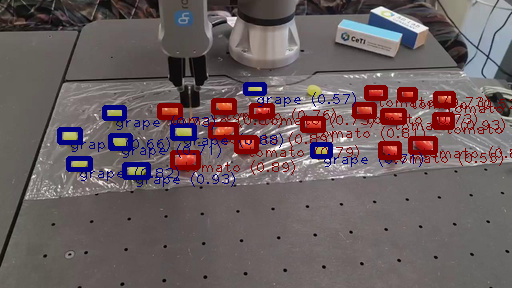

In [35]:
Image.fromarray(image_np)

## Compile the model for EdgeTPU

Finally, we'll compile the model using `edgetpu_compiler` so that the model can run on [Google Coral EdgeTPU](https://coral.ai/).

We start with installing the EdgeTPU compiler on Colab.

In [ ]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
!sudo apt-get update
!sudo apt-get install edgetpu-compiler

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  2537  100  2537    0     0  59000      0 --:--:-- --:--:-- --:--:-- 59000
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 https://packages.cloud.google.com/apt coral-edgetpu-stable InRelease [6,722 B]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/m

**Note:** When training the model using a custom dataset, beware that if your dataset includes more than 20 classes, you'll probably have slower inference speeds compared to if you have fewer classes. This is due to an aspect of the EfficientDet architecture in which a certain layer cannot compile for the Edge TPU when it carries more than 20 classes.

Before compiling the `.tflite` file for the Edge TPU, it's important to consider whether your model will fit into the Edge TPU memory. 

The Edge TPU has approximately 8 MB of SRAM for [caching model paramaters](https://coral.ai/docs/edgetpu/compiler/#parameter-data-caching), so any model close to or over 8 MB will not fit onto the Edge TPU memory. That means the inference times are longer, because some model parameters must be fetched from the host system memory.

One way to elimiate the extra latency is to use [model pipelining](https://coral.ai/docs/edgetpu/pipeline/), which splits the model into segments that can run on separate Edge TPUs in series. This can significantly reduce the latency for big models.

The following table provides recommendations for the number of Edge TPUs to use with each EfficientDet-Lite model.

| Model architecture | Minimum TPUs | Recommended TPUs
|--------------------|-------|-------|
| EfficientDet-Lite0 | 1     | 1     |
| EfficientDet-Lite1 | 1     | 1     |
| EfficientDet-Lite2 | 1     | 2     |
| EfficientDet-Lite3 | 2     | 2     |
| EfficientDet-Lite4 | 2     | 3     |

If you need extra Edge TPUs for your model, then update `NUMBER_OF_TPUS` here:

In [ ]:
NUMBER_OF_TPUS = 1

!edgetpu_compiler android.tflite --num_segments=$NUMBER_OF_TPUS

Edge TPU Compiler version 16.0.384591198
Started a compilation timeout timer of 180 seconds.

Model compiled successfully in 3127 ms.

Input model: android.tflite
Input size: 4.22MiB
Output model: android_edgetpu.tflite
Output size: 5.57MiB
On-chip memory used for caching model parameters: 4.21MiB
On-chip memory remaining for caching model parameters: 3.29MiB
Off-chip memory used for streaming uncached model parameters: 0.00B
Number of Edge TPU subgraphs: 1
Total number of operations: 267
Operation log: android_edgetpu.log

Model successfully compiled but not all operations are supported by the Edge TPU. A percentage of the model will instead run on the CPU, which is slower. If possible, consider updating your model to use only operations supported by the Edge TPU. For details, visit g.co/coral/model-reqs.
Number of operations that will run on Edge TPU: 264
Number of operations that will run on CPU: 3
See the operation log file for individual operation details.
Compilation child proces

Finally, we'll copy the metadata, including the label file, from the original TensorFlow Lite model to the EdgeTPU model.

In [ ]:
populator_dst = metadata.MetadataPopulator.with_model_file('android_edgetpu.tflite')

with open('android.tflite', 'rb') as f:
  populator_dst.load_metadata_and_associated_files(f.read())

populator_dst.populate()
updated_model_buf = populator_dst.get_model_buffer()

In [ ]:
# Download the TFLite model compiled for EdgeTPU to your local computer.
from google.colab import files
files.download('android_edgetpu.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>